In [23]:
import seaborn as sns
import pylab as rcParams
import matplotlib.pyplot as plt
from matplotlib import rc
import matplotlib 
import pandas as pd 
import numpy as np
from keras.models import Sequential
from keras.layers import Dense, Dropout,GRU
from sklearn.preprocessing import MinMaxScaler
from  sklearn.model_selection import TimeSeriesSplit
from keras.callbacks import EarlyStopping
from tcn import TCN
import tensorflow.keras.optimizers as Optimizer
import keras_tuner as kt
import tensorflow as tf

In [24]:
df=pd.read_csv('/home/j/usfq/tesis/StockPredictionModels/Data/Complete.csv')
df

,Date,ticker_symbol,p_sentiment,Open,High,Low,Close,unrate,psr,m2,dspic,pce,reer,ir,ffer,tcs,indpro,ccpi
0,2015-01-02,AAPL,0.766185,27.847500,27.860001,26.837500,27.332500,5.7,8.0,11759.1,13224.7,12036.5,106.11,1.881500,0.114839,1069010.0,102.8479,239.811
1,2015-01-02,AMZN,0.506131,15.629000,15.737500,15.348000,15.426000,5.7,8.0,11759.1,13224.7,12036.5,106.11,1.881500,0.114839,1069010.0,102.8479,239.811
2,2015-01-02,GOOG,0.846197,26.378078,26.490770,26.133251,26.168653,5.7,8.0,11759.1,13224.7,12036.5,106.11,1.881500,0.114839,1069010.0,102.8479,239.811
3,2015-01-02,GOOGL,0.819823,26.629999,26.790001,26.393999,26.477501,5.7,8.0,11759.1,13224.7,12036.5,106.11,1.881500,0.114839,1069010.0,102.8479,239.811
4,2015-01-02,MSFT,0.795557,46.660000,47.419998,46.540001,46.759998,5.7,8.0,11759.1,13224.7,12036.5,106.11,1.881500,0.114839,1069010.0,102.8479,239.811
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
7539,2019-12-31,AMZN,0.715115,92.099998,92.663002,91.611504,92.391998,3.6,7.3,15416.2,14844.1,14686.3,116.51,1.862857,1.550968,1458485.0,101.6179,265.651
7540,2019-12-31,GOOG,0.656211,66.505501,66.900002,66.454247,66.850998,3.6,7.3,15416.2,14844.1,14686.3,116.51,1.862857,1.550968,1458485.0,101.6179,265.651
7541,2019-12-31,GOOGL,0.777357,66.789497,67.032997,66.606499,66.969498,3.6,7.3,15416.2,14844.1,14686.3,116.51,1.862857,1.550968,1458485.0,101.6179,265.651
7542,2019-12-31,MSFT,0.683018,156.770004,157.770004,156.449997,157.699997,3.6,7.3,15416.2,14844.1,14686.3,116.51,1.862857,1.550968,1458485.0,101.6179,265.651


In [25]:
#turn date into unix time
#df['Date'] = pd.to_datetime(df['Date'])
#df['Date'] = df['Date'].apply(lambda x: x.timestamp())
#df

In [26]:
#generate new dataframes for each ticker_symbol
df_dict={}
for key in df['ticker_symbol'].unique():
    df_dict[key]=df[df['ticker_symbol']==key]
    df_dict[key]=df_dict[key].drop(columns=['ticker_symbol'])
    df_dict[key]=df_dict[key].sort_values(by=['Date']).reset_index(drop=True)
    #df_dict[key]=df_dict[key].drop(columns=['Date'])
    print(key,df_dict[key].shape)
    print(df_dict[key].head(-1))

AAPL (1254, 17)
            Date  p_sentiment       Open       High        Low      Close  \
0     2015-01-02     0.766185  27.847500  27.860001  26.837500  27.332500   
1     2015-01-05     0.846650  27.072500  27.162500  26.352501  26.562500   
2     2015-01-06     0.712894  26.635000  26.857500  26.157499  26.565001   
3     2015-01-07     0.744531  26.799999  27.049999  26.674999  26.937500   
4     2015-01-08     0.769826  27.307501  28.037500  27.174999  27.972500   
...          ...          ...        ...        ...        ...        ...   
1248  2019-12-23     0.761074  70.132500  71.062500  70.092499  71.000000   
1249  2019-12-24     0.775495  71.172501  71.222504  70.730003  71.067497   
1250  2019-12-26     0.742264  71.205002  72.495003  71.175003  72.477501   
1251  2019-12-27     0.768797  72.779999  73.492500  72.029999  72.449997   
1252  2019-12-30     0.746877  72.364998  73.172501  71.305000  72.879997   

      unrate  psr       m2    dspic      pce    reer       

In [27]:
ticker='TSLA'

In [28]:
df=df_dict[ticker].copy()
df.head()

,Date,p_sentiment,Open,High,Low,Close,unrate,psr,m2,dspic,pce,reer,ir,ffer,tcs,indpro,ccpi
0,2015-01-02,0.710122,14.858000,14.883333,14.217333,14.620667,5.7,8.0,11759.1,13224.7,12036.5,106.11,1.8815,0.114839,1069010.0,102.8479,239.811
1,2015-01-05,0.728551,14.303333,14.433333,13.810667,14.006000,5.7,8.0,11759.1,13224.7,12036.5,106.11,1.8815,0.114839,1069010.0,102.8479,239.811
2,2015-01-06,0.658187,14.004000,14.280000,13.614000,14.085333,5.7,8.0,11759.1,13224.7,12036.5,106.11,1.8815,0.114839,1069010.0,102.8479,239.811
3,2015-01-07,0.646626,14.223333,14.318667,13.985333,14.063333,5.7,8.0,11759.1,13224.7,12036.5,106.11,1.8815,0.114839,1069010.0,102.8479,239.811
4,2015-01-08,0.696584,14.187333,14.253333,14.000667,14.041333,5.7,8.0,11759.1,13224.7,12036.5,106.11,1.8815,0.114839,1069010.0,102.8479,239.811


In [29]:
#putting the close column on the last position
df=df[['Date',
'p_sentiment',
 'Open',
 'High',
 'Low',
 'unrate',
 'psr',
 'm2',
 'dspic',
 'pce',
 'reer',
 'ir',
 'ffer',
 'tcs',
 'indpro',
 'ccpi',
  'Close',]]

In [30]:
dates = pd.to_datetime(df['Date'])

In [31]:
cols=list(df)[1:]
cols

['p_sentiment',
 'Open',
 'High',
 'Low',
 'unrate',
 'psr',
 'm2',
 'dspic',
 'pce',
 'reer',
 'ir',
 'ffer',
 'tcs',
 'indpro',
 'ccpi',
 'Close']

In [32]:
df_for_training = df[cols].astype(float)

In [33]:
scaler = MinMaxScaler(feature_range=(0, 1))
scaled_data = scaler.fit_transform(df_for_training)

In [34]:
print(scaled_data)

[[0.73349331 0.27521525 0.24356139 ... 0.77924797 0.         0.26330631]
 [0.77183473 0.24678828 0.21948349 ... 0.77924797 0.         0.23121105]
 [0.62544497 0.23144731 0.21127918 ... 0.77924797 0.         0.23535347]
 ...
 [0.50389745 1.         1.         ... 0.57323507 1.         0.99805053]
 [0.30306162 0.97878229 0.97749165 ... 0.57323507 1.         0.9434678 ]
 [0.28882563 0.89749897 0.94998933 ... 0.57323507 1.         0.95610395]]


In [35]:
#split scaled data into training, val and testing
#train_data=scaled_data[0:1000,:]
#val_data=scaled_data[1000:1125,:]
#test_data=scaled_data[1125:,:]

In [36]:
n_future = 1 # Number of days we want to predict into the future
n_past = 7 # Number of past days we want to use to predict the future

In [37]:
X=[]
y=[]
for i in range(n_past, len(scaled_data) - n_future +1):
    X.append(scaled_data[i - n_past:i, 0:df_for_training.shape[1]])
    y.append(scaled_data[i + n_future - 1:i + n_future, len(cols)-1])

In [38]:
#shape of X_s and y_s
X, y = np.array(X), np.array(y)
print(X.shape)
print(y.shape)

(1251, 7, 16)
(1251, 1)


In [39]:
size=1230
X_train=X[0:size,:]
X_test=X[size:,:]
y_train=y[0:size,:]
y_test=y[size:,:]

#early stopping

In [40]:
def model_builder(hp):
    model=Sequential()
    hp_ks=hp.Choice('kernel_size', values=[2, 4, 8,16,32,64,128,256,512])
    hp_nb=hp.Choice('nb_filters', values=[32, 64, 128, 256,512,1024])
    model.add(
    TCN(
        input_shape=(X_train.shape[1], X_train.shape[2]),
        kernel_size=hp_ks,
        dilations=[1, 2, 4, 8, 16, 32],
        return_sequences=False,
        activation='relu',
        nb_filters=hp_nb,
        padding='causal',
        #dropout_rate=0.25,
        kernel_initializer='he_normal',
    ) 
    )
    def symmetric_mean_absolute_percentage_error(y_true, y_pred):
        epsilon = 1e-7  # To avoid division by zero
        summation = tf.keras.backend.clip(tf.keras.backend.abs(y_true) + tf.keras.backend.abs(y_pred) + epsilon, epsilon, None)
        return 200. * tf.keras.backend.mean(tf.keras.backend.abs(y_pred - y_true) / summation)
    model.add(Dense(y_train.shape[1]))
    model.compile(optimizer='adam',loss=symmetric_mean_absolute_percentage_error,metrics=['mae'])
    return model

In [41]:
tuner = kt.Hyperband(model_builder,
                     objective='val_loss',
                     max_epochs=8,
                     factor=4,
                     project_name='hyperparameter_tuning')
early_stop=EarlyStopping(monitor='val_loss',patience=2)

In [42]:
tuner.search(X_train, y_train, epochs=10, validation_split=0.2, callbacks=[early_stop])
best_hps=tuner.get_best_hyperparameters(num_trials=1)[0]


Trial 10 Complete [00h 00m 09s]
val_loss: 16.523258209228516

Best val_loss So Far: 9.868424415588379
Total elapsed time: 00h 00m 56s


In [43]:
print(best_hps.values)

{'kernel_size': 16, 'nb_filters': 32, 'tuner/epochs': 8, 'tuner/initial_epoch': 2, 'tuner/bracket': 1, 'tuner/round': 1, 'tuner/trial_id': '0003'}


Epoch 1/1000
6/6 [==============================] - 3s 132ms/step - loss: 167.1697 - mae: 0.5579 - val_loss: 200.0000 - val_mae: 0.7417
Epoch 2/1000
6/6 [==============================] - 0s 12ms/step - loss: 200.0000 - mae: 1.0154 - val_loss: 200.0000 - val_mae: 0.8931
Epoch 3/1000
6/6 [==============================] - 0s 14ms/step - loss: 200.0000 - mae: 1.1423 - val_loss: 200.0000 - val_mae: 0.9154
Epoch 4/1000
6/6 [==============================] - 0s 12ms/step - loss: 200.0000 - mae: 1.1570 - val_loss: 200.0000 - val_mae: 0.8677
Epoch 5/1000
6/6 [==============================] - 0s 12ms/step - loss: 200.0000 - mae: 1.1055 - val_loss: 200.0000 - val_mae: 0.7719
Epoch 6/1000
6/6 [==============================] - 0s 13ms/step - loss: 200.0000 - mae: 1.0081 - val_loss: 200.0000 - val_mae: 0.6403
Epoch 7/1000
6/6 [==============================] - 0s 12ms/step - loss: 200.0000 - mae: 0.8632 - val_loss: 200.0000 - val_mae: 0.4471
Epoch 8/1000
6/6 [==============================] - 0s

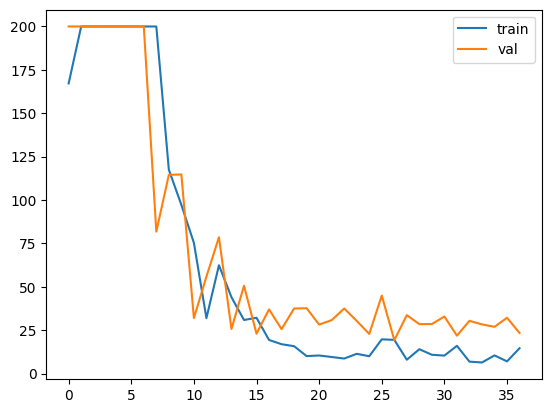

1/1 [==============================] - 0s 194ms/step
MAE: 1.927574672793434
(21,)
(21,)


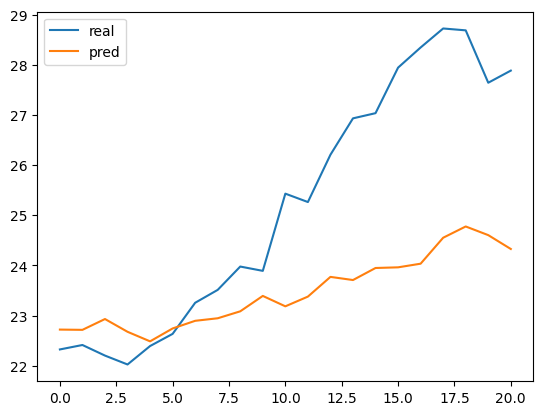

Epoch 1/1000
12/12 [==============================] - 2s 57ms/step - loss: 52.2909 - mae: 0.1120 - val_loss: 32.6160 - val_mae: 0.0765
Epoch 2/1000
12/12 [==============================] - 0s 8ms/step - loss: 42.3283 - mae: 0.1416 - val_loss: 58.5966 - val_mae: 0.0991
Epoch 3/1000
12/12 [==============================] - 0s 9ms/step - loss: 52.2060 - mae: 0.1378 - val_loss: 53.6176 - val_mae: 0.1718
Epoch 4/1000
12/12 [==============================] - 0s 9ms/step - loss: 44.4137 - mae: 0.1513 - val_loss: 21.6238 - val_mae: 0.0545
Epoch 5/1000
12/12 [==============================] - 0s 11ms/step - loss: 28.7906 - mae: 0.0792 - val_loss: 20.2390 - val_mae: 0.0524
Epoch 6/1000
12/12 [==============================] - 0s 11ms/step - loss: 27.5113 - mae: 0.0744 - val_loss: 28.8657 - val_mae: 0.0780
Epoch 7/1000
12/12 [==============================] - 0s 9ms/step - loss: 30.0743 - mae: 0.0773 - val_loss: 30.8075 - val_mae: 0.0825
Epoch 8/1000
12/12 [==============================] - 0s 9m

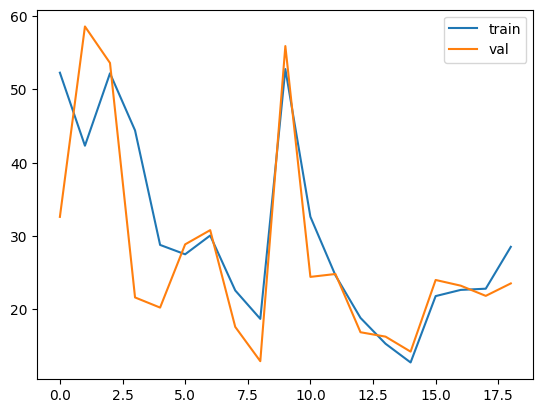

1/1 [==============================] - 0s 124ms/step
MAE: 10.03052848274449
(21,)
(21,)


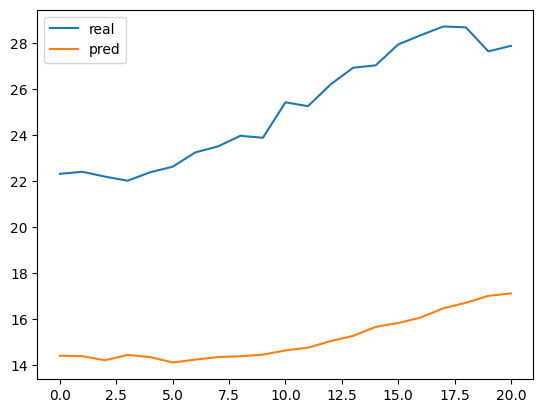

Epoch 1/1000
17/17 [==============================] - 3s 45ms/step - loss: 188.9690 - mae: 0.7243 - val_loss: 200.0000 - val_mae: 1.4285
Epoch 2/1000
17/17 [==============================] - 0s 10ms/step - loss: 200.0000 - mae: 0.8615 - val_loss: 200.0000 - val_mae: 0.9448
Epoch 3/1000
17/17 [==============================] - 0s 8ms/step - loss: 119.0502 - mae: 0.4264 - val_loss: 178.1580 - val_mae: 0.6373
Epoch 4/1000
17/17 [==============================] - 0s 9ms/step - loss: 101.0713 - mae: 0.2865 - val_loss: 52.2600 - val_mae: 0.2734
Epoch 5/1000
17/17 [==============================] - 0s 9ms/step - loss: 43.1966 - mae: 0.1276 - val_loss: 45.9863 - val_mae: 0.3610
Epoch 6/1000
17/17 [==============================] - 0s 8ms/step - loss: 95.7528 - mae: 0.5165 - val_loss: 17.6922 - val_mae: 0.1092
Epoch 7/1000
17/17 [==============================] - 0s 8ms/step - loss: 40.3017 - mae: 0.1067 - val_loss: 19.0060 - val_mae: 0.1161
Epoch 8/1000
17/17 [==============================] -

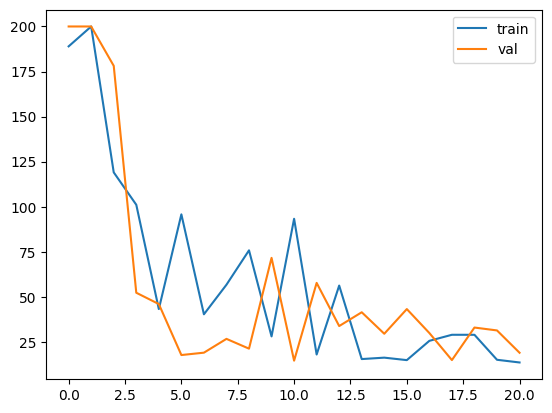

1/1 [==============================] - 0s 122ms/step
MAE: 5.504741356294177
(21,)
(21,)


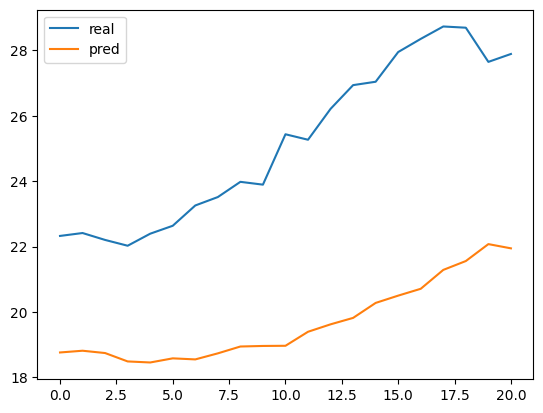

Epoch 1/1000
23/23 [==============================] - 3s 46ms/step - loss: 60.9850 - mae: 0.1830 - val_loss: 23.1228 - val_mae: 0.1535
Epoch 2/1000
23/23 [==============================] - 0s 9ms/step - loss: 57.2887 - mae: 0.2320 - val_loss: 25.0544 - val_mae: 0.1682
Epoch 3/1000
23/23 [==============================] - 0s 9ms/step - loss: 38.2461 - mae: 0.1338 - val_loss: 24.5656 - val_mae: 0.1653
Epoch 4/1000
23/23 [==============================] - 0s 8ms/step - loss: 117.0677 - mae: 0.3067 - val_loss: 37.2890 - val_mae: 0.2717
Epoch 5/1000
23/23 [==============================] - 0s 8ms/step - loss: 54.2111 - mae: 0.1384 - val_loss: 29.3238 - val_mae: 0.2033
Epoch 6/1000
23/23 [==============================] - 0s 8ms/step - loss: 20.5194 - mae: 0.0681 - val_loss: 21.3421 - val_mae: 0.1414
Epoch 7/1000
23/23 [==============================] - 0s 9ms/step - loss: 49.0616 - mae: 0.1097 - val_loss: 13.3437 - val_mae: 0.0810
Epoch 8/1000
23/23 [==============================] - 0s 8ms

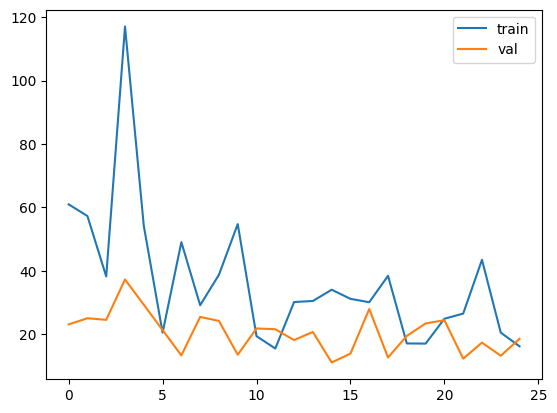

1/1 [==============================] - 0s 125ms/step
MAE: 1.3972824183175223
(21,)
(21,)


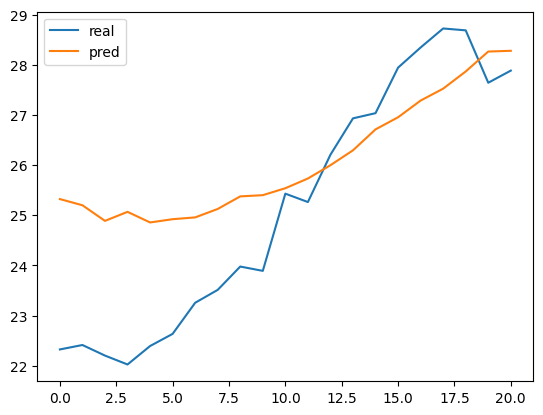

Epoch 1/1000
28/28 [==============================] - 2s 25ms/step - loss: 28.6475 - mae: 0.0922 - val_loss: 31.6487 - val_mae: 0.1684
Epoch 2/1000
28/28 [==============================] - 0s 9ms/step - loss: 53.2214 - mae: 0.2007 - val_loss: 55.4588 - val_mae: 0.4418
Epoch 3/1000
28/28 [==============================] - 0s 8ms/step - loss: 55.6405 - mae: 0.2294 - val_loss: 43.4446 - val_mae: 0.3195
Epoch 4/1000
28/28 [==============================] - 0s 8ms/step - loss: 61.6202 - mae: 0.2811 - val_loss: 11.5936 - val_mae: 0.0664
Epoch 5/1000
28/28 [==============================] - 0s 8ms/step - loss: 17.5474 - mae: 0.0581 - val_loss: 11.3437 - val_mae: 0.0656
Epoch 6/1000
28/28 [==============================] - 0s 8ms/step - loss: 22.8009 - mae: 0.0654 - val_loss: 9.9975 - val_mae: 0.0574
Epoch 7/1000
28/28 [==============================] - 0s 8ms/step - loss: 23.1220 - mae: 0.0819 - val_loss: 20.1401 - val_mae: 0.1267
Epoch 8/1000
28/28 [==============================] - 0s 8ms/s

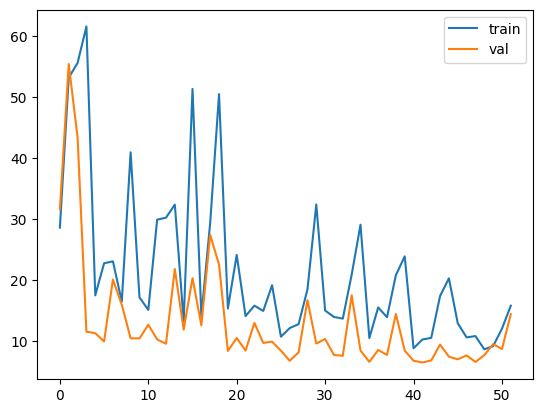

1/1 [==============================] - 0s 130ms/step
MAE: 1.7329051208844861
(21,)
(21,)


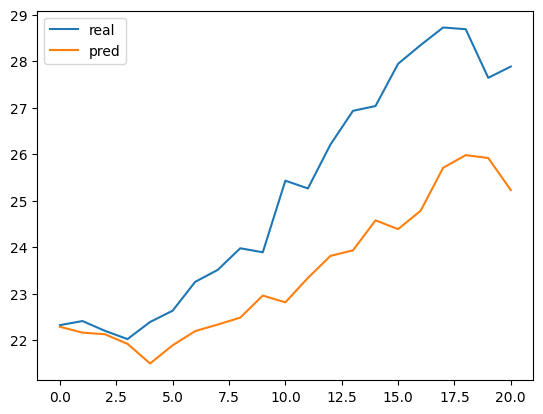

Epoch 1/1000
33/33 [==============================] - 3s 28ms/step - loss: 51.0991 - mae: 0.1656 - val_loss: 55.2821 - val_mae: 0.1648
Epoch 2/1000
33/33 [==============================] - 0s 8ms/step - loss: 44.7135 - mae: 0.1750 - val_loss: 11.1810 - val_mae: 0.0425
Epoch 3/1000
33/33 [==============================] - 0s 8ms/step - loss: 29.7388 - mae: 0.1216 - val_loss: 15.0799 - val_mae: 0.0630
Epoch 4/1000
33/33 [==============================] - 0s 9ms/step - loss: 49.1880 - mae: 0.1991 - val_loss: 21.7735 - val_mae: 0.0670
Epoch 5/1000
33/33 [==============================] - 0s 8ms/step - loss: 17.1969 - mae: 0.0705 - val_loss: 53.4663 - val_mae: 0.2484
Epoch 6/1000
33/33 [==============================] - 0s 7ms/step - loss: 27.4858 - mae: 0.1120 - val_loss: 20.9225 - val_mae: 0.0807
Epoch 7/1000
33/33 [==============================] - 0s 7ms/step - loss: 39.0709 - mae: 0.1117 - val_loss: 12.4973 - val_mae: 0.0415
Epoch 8/1000
33/33 [==============================] - 0s 8ms/

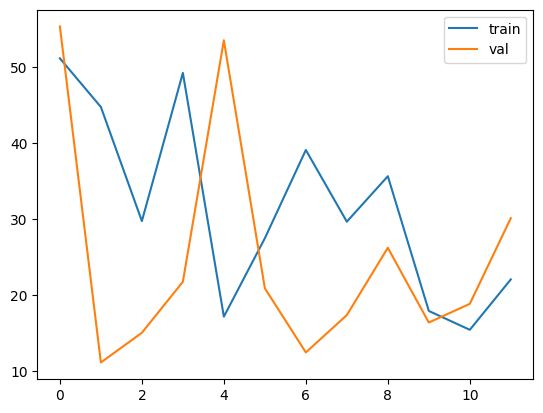

1/1 [==============================] - 0s 131ms/step
MAE: 1.3190521784319196
(21,)
(21,)


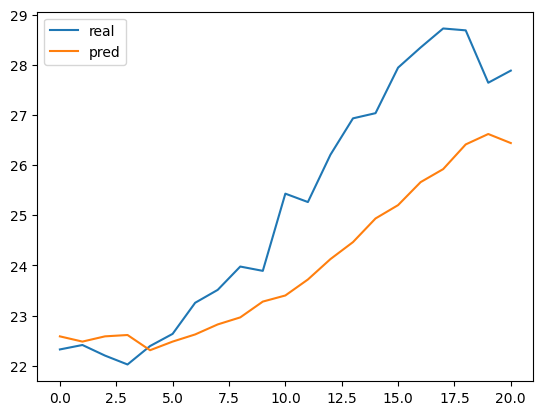

In [44]:
tscv = TimeSeriesSplit(n_splits=6)
y_test=np.repeat(y_test,16,axis=1)
y_test=scaler.inverse_transform(y_test)[:,-1] 
for train_index, val_index in tscv.split(X_train):
    early_stop=EarlyStopping(monitor='val_loss',patience=10)
    X_train, X_val = X[train_index], X[val_index]
    y_train, y_val = y[train_index], y[val_index]

    model=tuner.hypermodel.build(best_hps)
    history=model.fit(X_train,y_train,epochs=1000,validation_data=(X_val,y_val),shuffle=False, callbacks=[early_stop])
    plt.plot(history.history['loss'],label='train')
    plt.plot(history.history['val_loss'],label='val')
    plt.legend()
    plt.show()
    y_pred=model.predict(X_test)
    y_pred.shape


    pred=np.repeat(y_pred,16,axis=1)
    pred=scaler.inverse_transform(pred)[:,-1]

    #show MAE in prediction and real
    print('MAE:', np.mean(np.abs(pred-y_test)))
    print(pred.shape)
    print(y_test.shape)

    #plotting the results
    plt.plot(y_test, label='real')
    plt.plot(pred, label='pred') 
    plt.legend()
    plt.show()
